In [1]:
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import keras
import numpy as np
import pandas as pd
import config
import matplotlib.pyplot as plt
import seaborn as sns
import random

Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
sns.set(style='whitegrid')

In [4]:
engine = config.engine

In [6]:
all_prices_qry = 'SELECT postcode, lsoa_code, price / total_floor_area AS persqm ' \
                   'FROM train_cleaned ' \
                   'UNION ' \
                   'SELECT postcode, lsoa_code, price / total_floor_area AS persqm ' \
                   'FROM test_cleaned;'

all_prices = pd.read_sql(all_prices_qry, engine)

In [7]:
all_prices.shape

(2533, 3)

In [8]:
all_prices['sqrt_persqm'] = np.sqrt(all_prices['persqm'])

In [9]:
lsoa_avg_persqm = (
    all_prices
    .groupby('lsoa_code')['persqm']
    .mean()
    .sort_values(ascending=False)
)
lsoa_avg_sqrt_persqm = all_prices.groupby('lsoa_code')['sqrt_persqm'].mean().sort_values(ascending=False)

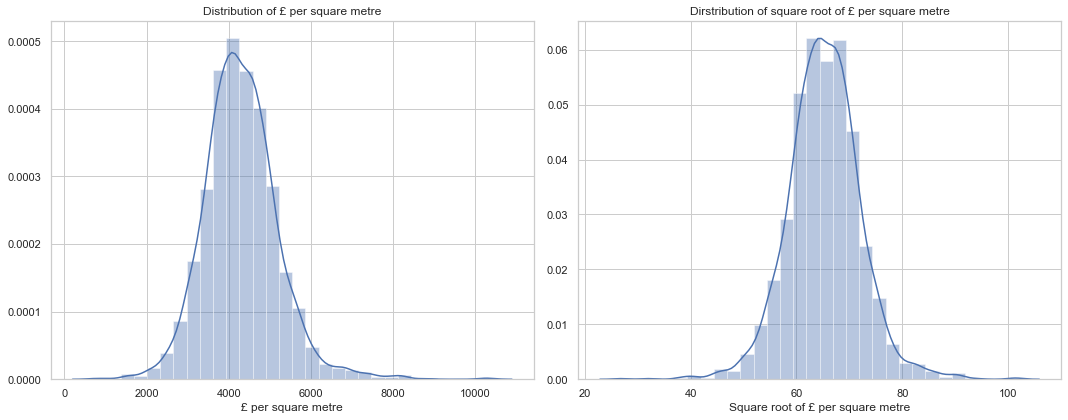

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.distplot(all_prices['persqm'], bins=30)
plt.xlabel('£ per square metre')
plt.title('Distribution of £ per square metre')
plt.subplot(122)
sns.distplot(all_prices['sqrt_persqm'], bins=30)
plt.xlabel('Square root of £ per square metre')
plt.title('Dirstribution of square root of £ per square metre')
plt.tight_layout()
plt.savefig('figures/persqm_distribution.png')
plt.show()

In [11]:
all_prices = all_prices.merge(lsoa_avg_sqrt_persqm, left_on='lsoa_code', right_index=True, suffixes=['','_lsoa_avg'])
all_prices.head()

,postcode,lsoa_code,persqm,sqrt_persqm,sqrt_persqm_lsoa_avg
0,HP13 6HH,E01017919,3571.428571,59.761430,63.670126
3,HP13 6EA,E01017919,3962.264151,62.946518,63.670126
19,HP13 6XJ,E01017919,4275.000000,65.383484,63.670126
293,HP13 6DN,E01017919,3507.462687,59.223835,63.670126
310,HP13 6DZ,E01017919,4068.965517,63.788443,63.670126


# Load images

In [12]:
import imageio
import glob
import os

In [13]:
img_path = 'images/images128/*.png'

In [14]:
postcodes = []
images = []

for img in glob.glob(img_path):
    postcodes.append(os.path.basename(img).replace('.png', ''))
    im = imageio.imread(img)
    images.append(im[:,:,:-1])

In [15]:
images = np.array(images)
images.shape

(1512, 128, 128, 3)

In [16]:
all_prices[~all_prices['postcode'].isin(postcodes)]

,postcode,lsoa_code,persqm,sqrt_persqm,sqrt_persqm_lsoa_avg


In [17]:
image_table = pd.DataFrame(list(zip(postcodes, images)), columns=['postcode', 'image'])

In [18]:
image_table.shape

(1512, 2)

In [19]:
data = all_prices.merge(image_table, on='postcode').loc[:, ['postcode', 'lsoa_code', 'sqrt_persqm_lsoa_avg', 'image']] \
    .drop_duplicates(subset=['postcode'])
data.head()

,postcode,lsoa_code,sqrt_persqm_lsoa_avg,image
0,HP13 6HH,E01017919,63.670126,"[[[84, 84, 76], [135, 131, 124], [124, 120, 10..."
3,HP13 6EA,E01017919,63.670126,"[[[28, 44, 20], [76, 98, 68], [76, 98, 68], [8..."
6,HP13 6XJ,E01017919,63.670126,"[[[132, 128, 116], [175, 167, 155], [89, 89, 7..."
8,HP13 6DN,E01017919,63.670126,"[[[121, 120, 108], [88, 88, 76], [89, 98, 74],..."
10,HP13 6DZ,E01017919,63.670126,"[[[76, 84, 68], [52, 68, 44], [72, 92, 64], [5..."


In [20]:
data.shape

(1194, 4)

In [21]:
import pickle as pkl

In [22]:
with open('images_and_prices.pkl', 'wb') as f:
    pkl.dump(data, f)